In [0]:
import numpy as np
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
import os
from datetime import datetime


from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras.callbacks import ModelCheckpoint,CSVLogger,LearningRateScheduler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import add
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import cifar10
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#data location path
PROJECT_DIR = r"D:\CA2_Data"

TRAIN_DIR = os.path.join(PROJECT_DIR, "Train")
VALIDATION_DIR = os.path.join(PROJECT_DIR, "Validation")
LOG_DIR = os.path.join(PROJECT_DIR, "Log")
TIMESTAMP = "{0:%Y-%m-%dT%H-%M-%S/}".format(datetime.now())

seed        = 29
np.random.seed(seed)

In [0]:
train_file_count = sum([len(files) for r, d, files in os.walk(TRAIN_DIR)])
test_file_count = sum([len(files) for r, d, files in os.walk(VALIDATION_DIR)])
print("Training images: ", train_file_count)
print("Validation images: ", test_file_count)

Training images:  2423
Validation images:  724


# Setup Model

In [0]:
# resLyr
def resLyr(inputs,
           numFilters=16,
           kernelSz=3,
           strides=1,
           activation='relu',
           batchNorm=True,
           convFirst=True,
           lyrName=None):
    convLyr = Conv2D(numFilters,
                       kernel_size=kernelSz,
                       strides=strides,
                       padding='same',
                       kernel_initializer='he_normal',
                       kernel_regularizer=l2(1e-4),
                       name=lyrName+'_conv' if lyrName else None)
    x = inputs
    if convFirst:
        x = convLyr(x)
        if batchNorm:
            x = BatchNormalization(name=lyrName+'_bn' if lyrName else None)(x)
        if activation is not None:
            x = Activation(activation,name=lyrName+'_'+activation if lyrName else None)(x)
    else:
        if batchNorm:
            x = BatchNormalization(name=lyrName+'_bn' if lyrName else None)(x)
        if activation is not None:
            x = Activation(activation,name=lyrName+'_'+activation if lyrName else None)(x)
        x = convLyr(x)

    return x

# resBlkV1
def resBlkV1(inputs,
             numFilters=16,
             numBlocks=3,
             downsampleOnFirst=True,
             names=None):
    x = inputs
    
    for run in range(0,numBlocks):
        strides = 1
        blkStr = str(run+1)

        if downsampleOnFirst and run == 0:
            strides = 2

        y = resLyr(inputs=x,
                   numFilters=numFilters,
                   strides=strides,
                   lyrName=names+'_Blk'+blkStr+'_Res1' if names else None)
        y = resLyr(inputs=y,
                   numFilters=numFilters,
                   activation=None,
                   lyrName=names+'_Blk'+blkStr+'_Res2' if names else None)
        
        if downsampleOnFirst and run == 0:
            x = resLyr(inputs=x,
                        numFilters=numFilters,
                        kernelSz=1,
                        strides=strides,
                        activation=None,
                        batchNorm=False,
                        lyrName=names+'_Blk'+blkStr+'_lin' if names else None)
            
        x = add([x,y],name=names+'_Blk'+blkStr+'_add' if names else None)
        x = Activation('relu',name=names+'_Blk'+blkStr+'_relu' if names else None)(x)

    return x

In [0]:
img_rows = 64
img_cols = 64
epochs = 200
batch_size = 32

optmz       = optimizers.Adam(lr=0.001)
modelname   = 'Model_v9.3' 

LOG_DIR = os.path.join(PROJECT_DIR, modelname)

In [4]:
# createResNetV1
def createResNetV1(inputShape=(img_rows,img_cols,3),
                   numClasses=3):
    inputs = Input(shape=inputShape)
    v = resLyr(inputs, lyrName='Inpt')
    v = resBlkV1(v,16,3,False,'Stg1')
    v = resBlkV1(v,32,3,True,'Stg2')
    v = resBlkV1(v,64,3,True,'Stg3')
    
    v = resLyr(inputs=v,
            numFilters=64,
            kernelSz=3,
            strides=1,
            activation='relu',
            batchNorm=True,
            convFirst=True,
            lyrName='v9.3'
            )

    v = AveragePooling2D(pool_size=4,name='AvgPool')(v)
    v = Flatten()(v)
    v = Dense(128)(v)
    outputs = Dense(numClasses,activation='softmax',kernel_initializer='he_normal')(v)
    model = Model(inputs=inputs,outputs=outputs)
    model.compile(loss='categorical_crossentropy',
                    optimizer=optmz,
                    metrics=['accuracy'])

    return model

# set up model
model       = createResNetV1()  # This is meant for training
modelGo     = createResNetV1()  # This is used for final testing

model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
Inpt_conv (Conv2D)              (None, 64, 64, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
Inpt_bn (BatchNormalization)    (None, 64, 64, 16)   64          Inpt_conv[0][0]                  
__________________________________________________________________________________________________
Inpt_relu (Activation)          (None, 64, 64, 16)   0           Inpt_bn[0]

## Fina Tune Model

In [0]:
# Create checkpoint for the training
def lrSchedule(epoch):
    lr  = 1e-3
    
    if epoch > 160:
        lr  *= 0.5e-3
        
    elif epoch > 140:
        lr  *= 1e-3
        
    elif epoch > 120:
        lr  *= 1e-2
        
    elif epoch > 80:
        lr  *= 1e-1
        
    print('Learning rate: ', lr)
    
    return lr

LRScheduler     = LearningRateScheduler(lrSchedule)

filepath        = os.path.join(PROJECT_DIR, modelname + ".hdf5")
checkpoint      = ModelCheckpoint(filepath, 
                                  monitor='val_acc', 
                                  verbose=0, 
                                  save_best_only=True, 
                                  mode='max')

# Log the epoch detail into csv
csv_logger      = CSVLogger(os.path.join(PROJECT_DIR,  modelname +'.csv'))
callbacks_list  = [checkpoint,csv_logger,LRScheduler]

## Create Image Data Generator

In [0]:
train_datagen = ImageDataGenerator(
                                    rotation_range=40,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.2,
                                    zoom_range=0.2)
validation_datagen = ImageDataGenerator()

train_generator = train_datagen.flow_from_directory(TRAIN_DIR,
                                                    target_size=(img_rows, img_cols),
                                                    batch_size=batch_size)

validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                        target_size=(img_rows, img_cols), 
                                                        batch_size=batch_size, shuffle=False)

Found 2423 images belonging to 3 classes.
Found 724 images belonging to 3 classes.


# Train Model

In [0]:
history = model.fit_generator(train_generator,
                    validation_data=validation_generator,
                    epochs=epochs, 
                    verbose=1,
                    workers=8,
                    steps_per_epoch=train_generator.n//batch_size,
                    validation_steps=validation_generator.n//batch_size,
                    callbacks=callbacks_list)

Learning rate:  0.001
Epoch 1/200
75/75 [==============================] - 13s 172ms/step - loss: 1.2462 - acc: 0.6211 - val_loss: 7.9326 - val_acc: 0.2628
Learning rate:  0.001
Epoch 2/200
75/75 [==============================] - 4s 50ms/step - loss: 0.8550 - acc: 0.7185 - val_loss: 1.8243 - val_acc: 0.6065
Learning rate:  0.001
Epoch 3/200
75/75 [==============================] - 4s 48ms/step - loss: 0.7985 - acc: 0.7491 - val_loss: 1.0166 - val_acc: 0.7344
Learning rate:  0.001
Epoch 4/200
75/75 [==============================] - 3s 43ms/step - loss: 0.7175 - acc: 0.7813 - val_loss: 1.0434 - val_acc: 0.6747
Learning rate:  0.001
Epoch 5/200
75/75 [==============================] - 4s 48ms/step - loss: 0.6815 - acc: 0.7913 - val_loss: 0.8076 - val_acc: 0.7571
Learning rate:  0.001
Epoch 6/200
75/75 [==============================] - 4s 48ms/step - loss: 0.6885 - acc: 0.7880 - val_loss: 0.6338 - val_acc: 0.8153
Learning rate:  0.001
Epoch 7/200
75/75 [==============================] -

Learning rate:  0.001
Epoch 54/200
75/75 [==============================] - 4s 49ms/step - loss: 0.3150 - acc: 0.9138 - val_loss: 0.4613 - val_acc: 0.8636
Learning rate:  0.001
Epoch 55/200
75/75 [==============================] - 4s 49ms/step - loss: 0.3031 - acc: 0.9258 - val_loss: 0.5428 - val_acc: 0.8523
Learning rate:  0.001
Epoch 56/200
75/75 [==============================] - 4s 50ms/step - loss: 0.3038 - acc: 0.9210 - val_loss: 0.6993 - val_acc: 0.8054
Learning rate:  0.001
Epoch 57/200
75/75 [==============================] - 4s 57ms/step - loss: 0.2759 - acc: 0.9373 - val_loss: 0.4310 - val_acc: 0.8949
Learning rate:  0.001
Epoch 58/200
75/75 [==============================] - 4s 50ms/step - loss: 0.2902 - acc: 0.9268 - val_loss: 0.6891 - val_acc: 0.8224
Learning rate:  0.001
Epoch 59/200
75/75 [==============================] - 4s 50ms/step - loss: 0.3075 - acc: 0.9180 - val_loss: 0.8084 - val_acc: 0.7741
Learning rate:  0.001
Epoch 60/200
75/75 [============================

75/75 [==============================] - 4s 52ms/step - loss: 0.1681 - acc: 0.9729 - val_loss: 0.4209 - val_acc: 0.8977
Learning rate:  0.0001
Epoch 107/200
75/75 [==============================] - 4s 49ms/step - loss: 0.1538 - acc: 0.9715 - val_loss: 0.4362 - val_acc: 0.8920
Learning rate:  0.0001
Epoch 108/200
75/75 [==============================] - 4s 49ms/step - loss: 0.1583 - acc: 0.9795 - val_loss: 0.4157 - val_acc: 0.8963
Learning rate:  0.0001
Epoch 109/200
75/75 [==============================] - 4s 50ms/step - loss: 0.1489 - acc: 0.9762 - val_loss: 0.4831 - val_acc: 0.8793
Learning rate:  0.0001
Epoch 110/200
75/75 [==============================] - 4s 49ms/step - loss: 0.1629 - acc: 0.9767 - val_loss: 0.4241 - val_acc: 0.8935
Learning rate:  0.0001
Epoch 111/200
75/75 [==============================] - 4s 50ms/step - loss: 0.1455 - acc: 0.9816 - val_loss: 0.4172 - val_acc: 0.8977
Learning rate:  0.0001
Epoch 112/200
75/75 [==============================] - 4s 51ms/step - lo

75/75 [==============================] - 4s 49ms/step - loss: 0.1312 - acc: 0.9854 - val_loss: 0.4361 - val_acc: 0.9034
Learning rate:  1e-06
Epoch 159/200
75/75 [==============================] - 4s 50ms/step - loss: 0.1412 - acc: 0.9820 - val_loss: 0.4348 - val_acc: 0.9034
Learning rate:  1e-06
Epoch 160/200
75/75 [==============================] - 4s 50ms/step - loss: 0.1323 - acc: 0.9841 - val_loss: 0.4367 - val_acc: 0.9034
Learning rate:  1e-06
Epoch 161/200
75/75 [==============================] - 4s 50ms/step - loss: 0.1354 - acc: 0.9833 - val_loss: 0.4353 - val_acc: 0.9034
Learning rate:  5e-07
Epoch 162/200
75/75 [==============================] - 4s 51ms/step - loss: 0.1404 - acc: 0.9816 - val_loss: 0.4366 - val_acc: 0.9034
Learning rate:  5e-07
Epoch 163/200
75/75 [==============================] - 4s 53ms/step - loss: 0.1403 - acc: 0.9816 - val_loss: 0.4362 - val_acc: 0.9034
Learning rate:  5e-07
Epoch 164/200
75/75 [==============================] - 4s 55ms/step - loss: 0.

# Model Evaluation

## Comparison between Training and Validation Dataset for Accuracy and Loss

In [0]:
Y_pred = model.predict_generator(validation_generator, workers=12, verbose=1)
y_pred = np.argmax(Y_pred, axis=1)

y_label = validation_generator.classes
finalScore = metrics.accuracy_score(y_label, y_pred)
print("Best accuracy (on testing dataset): %.2f%%" % (finalScore*100))

23/23 [==============================] - 1s 35ms/step
Best accuracy (on testing dataset): 90.33%


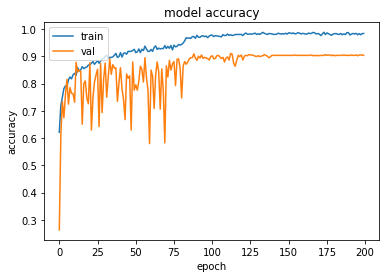

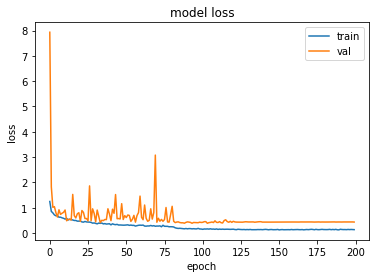

In [0]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

### Confusion Matrix

In [0]:
#Confution Matrix and Classification Report
Y_pred = model.predict_generator(validation_generator, steps=np.math.ceil(validation_generator.samples/validation_generator.batch_size), verbose=1, workers=0)
y_pred = np.argmax(Y_pred, axis=1)

print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))

23/23 [==============================] - 1s 57ms/step
Confusion Matrix
[[271  18   8]
 [  7 205   6]
 [ 11  20 178]]


## Classification Report

In [0]:
target_names = list(validation_generator.class_indices.keys())
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

                 precision    recall  f1-score   support

    food_resize       0.94      0.91      0.92       297
landmark_resize       0.84      0.94      0.89       218
  people_resize       0.93      0.85      0.89       209

       accuracy                           0.90       724
      macro avg       0.90      0.90      0.90       724
   weighted avg       0.91      0.90      0.90       724



# Plot Model

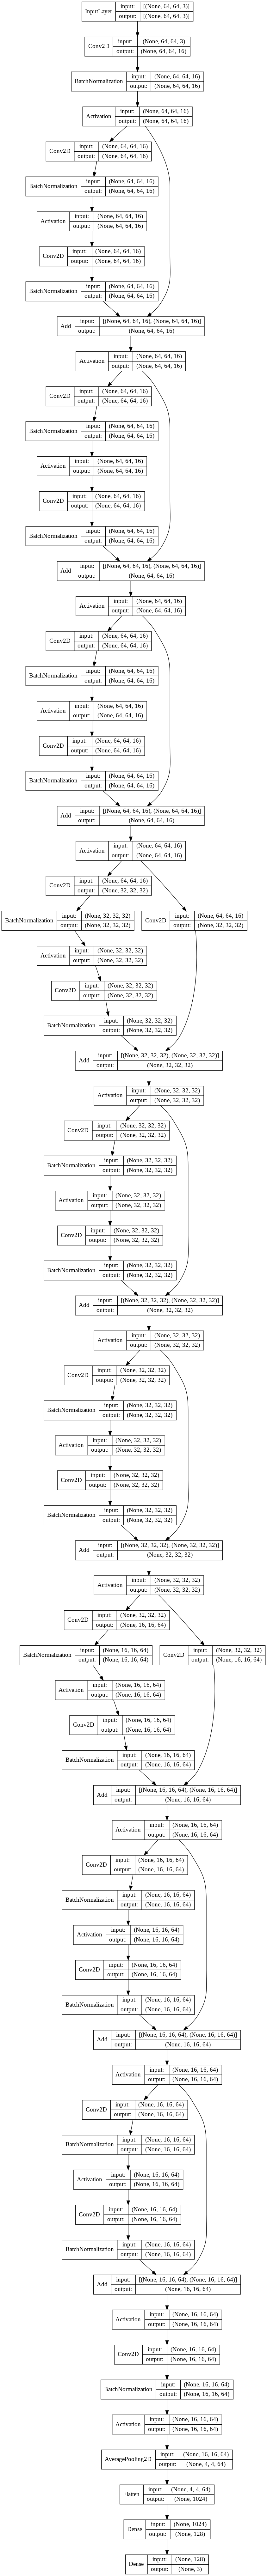

In [7]:
from tensorflow.keras.utils import plot_model

plot_model(model, 
#            to_file=os.path.join(PROJECT_DIR, modelname+'_model.png'), 
           to_file='v9.3_model.png',
           show_shapes=True, 
           show_layer_names=False,
           rankdir='TB')